2024-05-31 14:12:13,860 - qm - INFO     - Starting session: 4ad88f4a-fd45-429b-b292-bd9f4b591da0
Circuit context


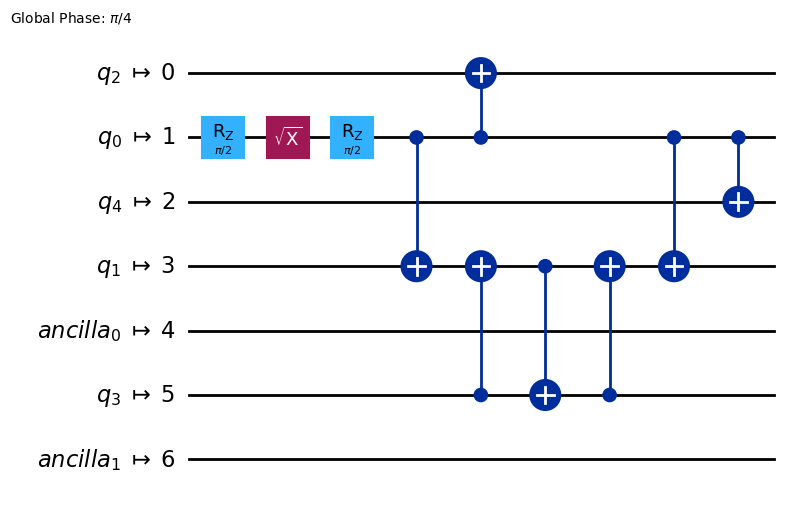

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from template_configurations.qiskit.gate_level import (
    q_env_config as gate_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironmentV2
from context_aware_quantum_environment import ContextAwareQuantumEnvironmentV2
from gymnasium.wrappers import RescaleAction, ClipAction

circuit_context.draw("mpl")

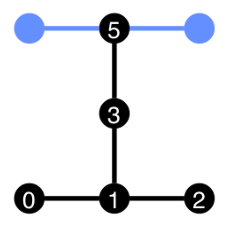

In [2]:
from qiskit.visualization import plot_circuit_layout

if gate_q_env_config.backend is not None and circuit_context.layout is not None:
    fig = plot_circuit_layout(
        circuit_context, gate_q_env_config.backend_config.backend, view="physical"
    )
print(gate_q_env_config.backend)
fig

In [3]:
use_context = True
if use_context:
    q_env = ContextAwareQuantumEnvironmentV2(
        gate_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironmentV2(gate_q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

Aer Backend created out of backend <qiskit_ibm_runtime.fake_provider.backends.jakarta.fake_jakarta.FakeJakartaV2 object at 0x3634f6710>


/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


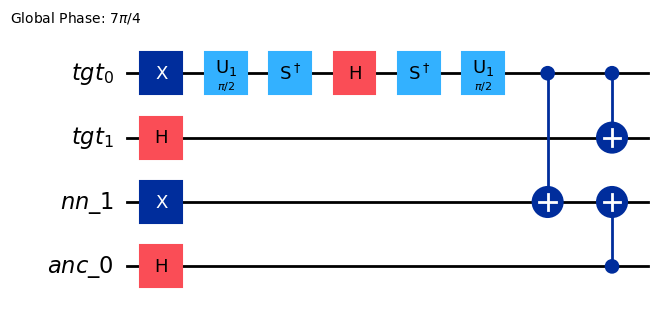

In [8]:
q_env.target.input_states[0][102].target_state.circuit.decompose().draw("mpl")

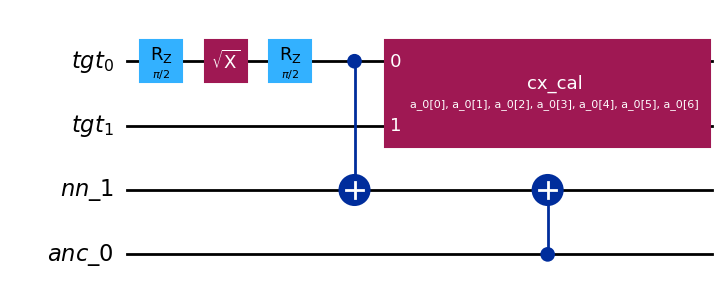

In [9]:
q_env.circuits[0].draw("mpl", style="iqp")

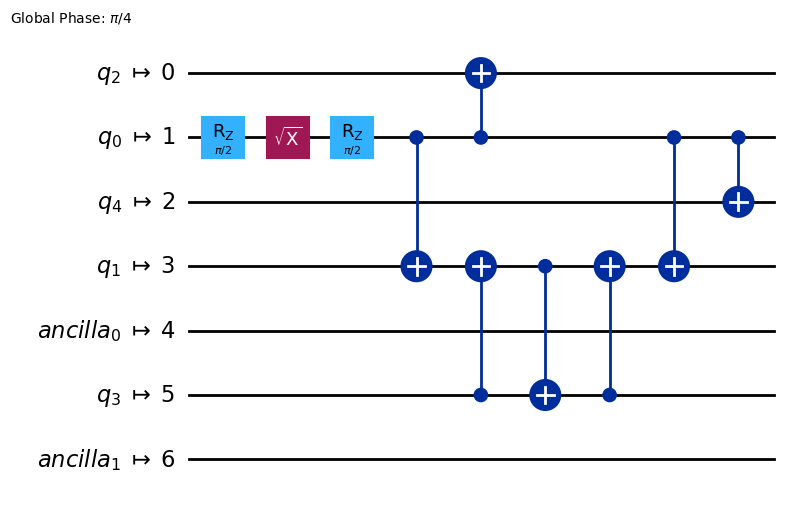

In [10]:
fig = None
if use_context:
    fig = q_env.circuit_context.draw("mpl")
fig

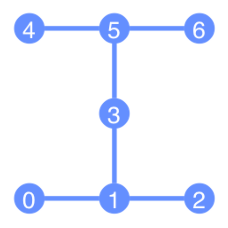

In [11]:
from qiskit.visualization import plot_gate_map

fig = None
if q_env.backend is not None and q_env.backend_info.coupling_map.size() != 0:
    fig = plot_gate_map(q_env.backend)
fig

In [12]:
from helper_functions import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = Path.cwd().parent.parent.parent / "template_configurations" / file_name

agent_config = load_from_yaml_file(file_location)

In [13]:
from ppo import CustomPPO

ppo_agent = CustomPPO(agent_config, rescaled_env)

In [14]:
q_env.target_instruction

CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(7, 'q'), 1), Qubit(QuantumRegister(7, 'q'), 0)), clbits=())

In [15]:
q_env.layout

[Layout({
 1: Qubit(QuantumRegister(2, 'tgt'), 0),
 0: Qubit(QuantumRegister(2, 'tgt'), 1),
 5: Qubit(QuantumRegister(1, 'nn_1'), 0),
 3: Qubit(QuantumRegister(1, 'anc_0'), 0)
 })]

  0%|          | 0/500 [00:00<?, ?it/s]/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/base_q_env.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


Fidelity stored 0.15574816944041622
Sending Estimator job...


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/base_q_env.py:745: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]
  0%|          | 1/500 [00:09<1:19:34,  9.57s/it]

Finished Estimator job
Time taken 9.4065260887146
Fidelity stored 0.17366743945194282
Sending Estimator job...


  0%|          | 1/500 [00:16<2:14:48, 16.21s/it]


KeyboardInterrupt: 

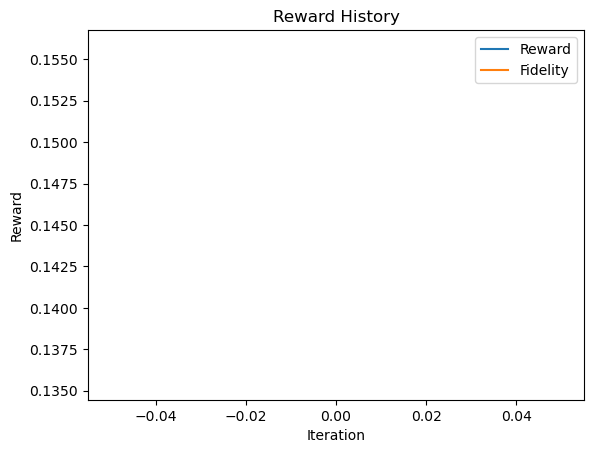

In [16]:
ppo_agent.train(
    total_updates=500, print_debug=False, num_prints=10, clear_history=False
)

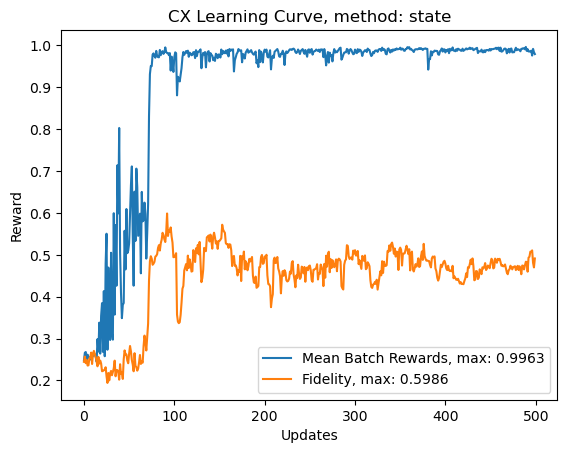

In [14]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method}"
)
plt.legend()
plt.show()

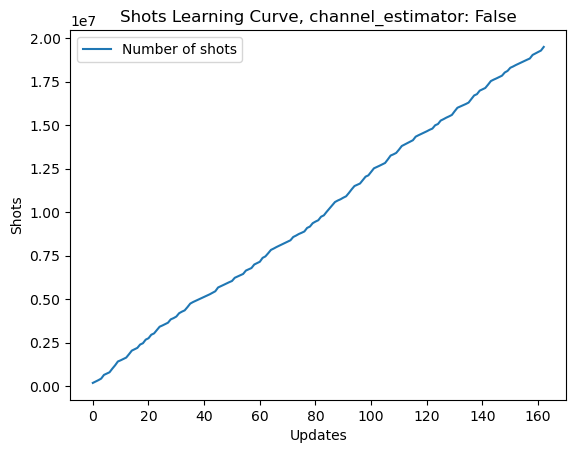

In [15]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, channel_estimator: {q_env.config.channel_estimator}")
plt.legend()

In [16]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

Number of shots required for convergence: [ 181760  261120  340480  430080  642560  716800  793600 1000960 1192960
 1413120 1482240 1559040 1638400 1832960 2037760 2114560 2196480 2388480
 2462720 2670080 2749440 2951680 3028480 3217920 3412480 3484160 3563520
 3642880 3834880 3906560 3996160 4188160 4277760 4352000 4538880 4741120
 4830720 4904960 4981760 5053440 5130240 5204480 5276160 5360640 5450240
 5667840 5742080 5818880 5898240 5972480 6041600 6225920 6300160 6374400
 6446080 6640640 6712320 6786560 6988800 7070720]


In [17]:
q_env.optimal_action / np.pi

array([0., 0., 0., 0., 0., 0., 0.])

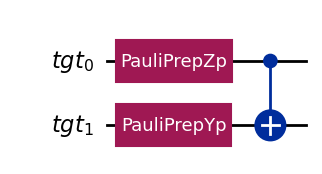

In [20]:
q_env.target.input_states[0][3].target_state.circuit.draw("mpl")

In [22]:
q_env.target.input_states[0][3].target_state.dm.dims()

(2, 2)

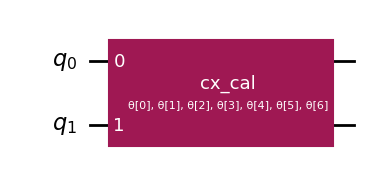

In [24]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CXGate
from qiskit.circuit import ParameterVector

qr = QuantumRegister(2, "q")
qc = QuantumCircuit(qr)
theta = ParameterVector("θ", 7)
q_env.parametrized_circuit_func(
    qc, theta, qr, target=q_env.config.target, backend=q_env.backend
)
qc.draw("mpl")

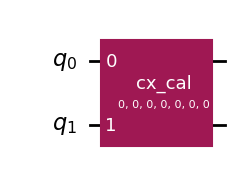

In [25]:
qc.assign_parameters(q_env.optimal_action, inplace=True)
qc.draw("mpl")

In [27]:
from qiskit.quantum_info import Operator

average_gate_fidelity(Operator(qc), q_env.target.gate)

0.4